```
This software is part of GPU Ocean. 

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```


# Finite Volume Details

In this notebook, we want to look into details in the slope reconstruction and flux evaluations of KP and CDKLM.

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16, KP07
from gpuocean.utils import Common, IPythonMagic

In [3]:
%cuda_context_handler gpu_ctx

In [14]:
# Set initial conditions common to all simulators
dt = 1
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 201, "ny": 201,
"dx": 100.0, "dy": 100.0,
"dt": dt,
"g": 9.81,
"f": 0.0012*20,
"coriolis_beta": 0, #1.0e-6,
"r": 0.0
}

In [15]:
def plotstate(eta, hu, hv, title, vmax=0.05):
    fig = plt.figure(figsize=(14,4))
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta, vmin=-0.001, vmax=0.001, origin='lower')
    plt.colorbar(sp_eta, ax= ax_eta, shrink=0.5)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(hu, vmin=-vmax, vmax=vmax, origin='lower')
    plt.colorbar(sp_u, ax= ax_u, shrink=0.5)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(hv, vmin=-vmax, vmax=vmax, origin='lower')
    plt.colorbar(sp_v, ax= ax_v, shrink=0.5)
    plt.suptitle(title)

### Spin up simulation state that we want to look closer at 

Use standard upwind CDKLM 

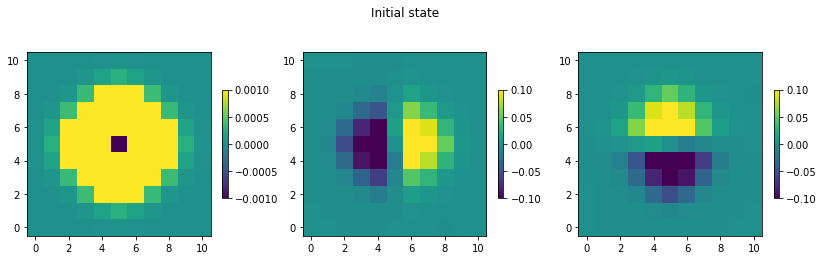

In [16]:
from importlib import reload
reload(CDKLM16)

ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H_const = 60.0
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_const
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

midx = sim_args["nx"]//2 
midy = sim_args["ny"]//2 

eta0[midy+2,midx+2] = 0.1
#eta0[midy+2-4:midy+2+4, midx+2-4:midx+2+4] = 0.1

#Initialize simulator
fvm_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0 }
sim = CDKLM16.CDKLM16(**fvm_args, **sim_args, 
                      flux_delimiter=0.0, rk_order= 2)
sim.step(6*dt)
eta, hu, hv = sim.download(interior_domain_only=True)

plotstate(eta[midy-5:midy+6,midx-5:midx+6], 
          hu[ midy-5:midy+6,midx-5:midx+6], 
          hv[ midy-5:midy+6,midx-5:midx+6], 
          "Initial state", vmax=0.1)

In [17]:
# Chek that we have the midpoint:
print(eta[midy,  midx-1], eta[midy,  midx], eta[midy,  midx+1])
print(eta[midy-1,  midx], eta[midy,  midx], eta[midy+1,  midx])

print(hu[midy,  midx-1], hu[midy,  midx], hu[midy,  midx+1])
print(hu[midy-1,  midx], hu[midy,  midx], hu[midy+1,  midx])

print(hv[midy,  midx-1], hv[midy,  midx], hv[midy,  midx+1])
print(hv[midy-1,  midx], hv[midy,  midx], hv[midy+1,  midx])




0.0019930229 -0.002124309 0.0019930229
0.0019930229 -0.002124309 0.0019930229
-0.18291607 0.0 0.18291607
-0.014311835 0.0 0.014311835
0.014311835 0.0 -0.014311835
-0.18291607 0.0 0.18291607


### Look at reconstruction only

extra when reconstruct eta CDKLM:  [6.0999179e-07 7.1000682e-06 6.1134357e-05 2.5709756e-04 5.5586227e-04
 7.4581039e-04 4.5781524e-04 1.9093019e-04 4.7742928e-05 5.6819958e-06
 4.5679064e-07]
extra when reconstruct eta CDKLM:  [6.0999179e-07 7.1000682e-06 6.1134357e-05 2.5709756e-04 5.5586227e-04
 7.4581039e-04 4.5781524e-04 1.9093019e-04 4.7742928e-05 5.6819958e-06
 4.5679064e-07]
extra when reconstruct eta CDKLM:  [6.0999179e-07 7.1000682e-06 6.1134357e-05 2.5709756e-04 5.5586227e-04
 7.4581039e-04 4.5781524e-04 1.9093019e-04 4.7742928e-05 5.6819958e-06
 4.5679064e-07]
extra when reconstruct eta CDKLM:  [6.0999179e-07 7.1000682e-06 6.1134357e-05 2.5709756e-04 5.5586227e-04
 7.4581039e-04 4.5781524e-04 1.9093019e-04 4.7742928e-05 5.6819958e-06
 4.5679064e-07]
extra when reconstruct eta CDKLM:  [6.0999179e-07 7.1000682e-06 6.1134357e-05 2.5709756e-04 5.5586227e-04
 7.4581039e-04 4.5781524e-04 1.9093019e-04 4.7742928e-05 5.6819958e-06
 4.5679064e-07]
extra when reconstruct eta CDKLM:  

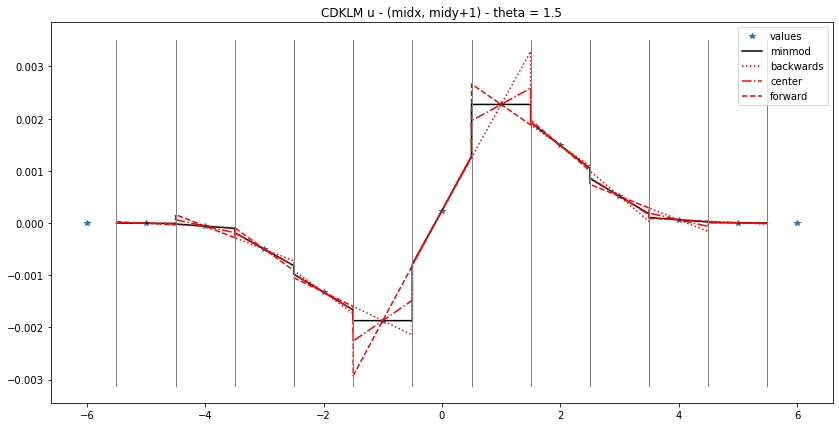

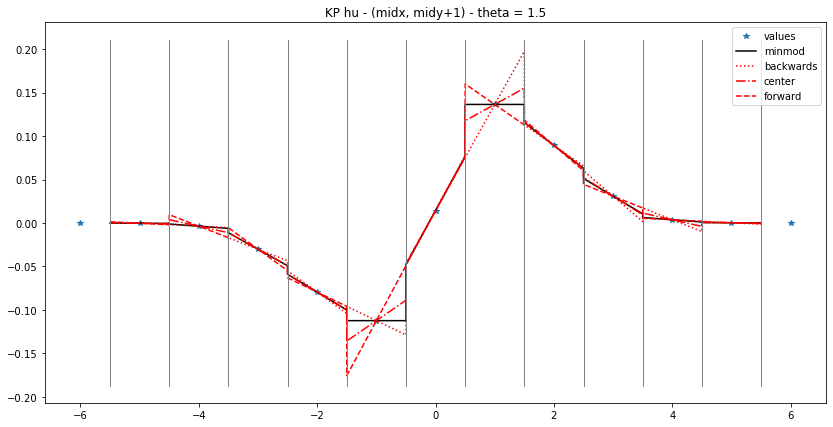

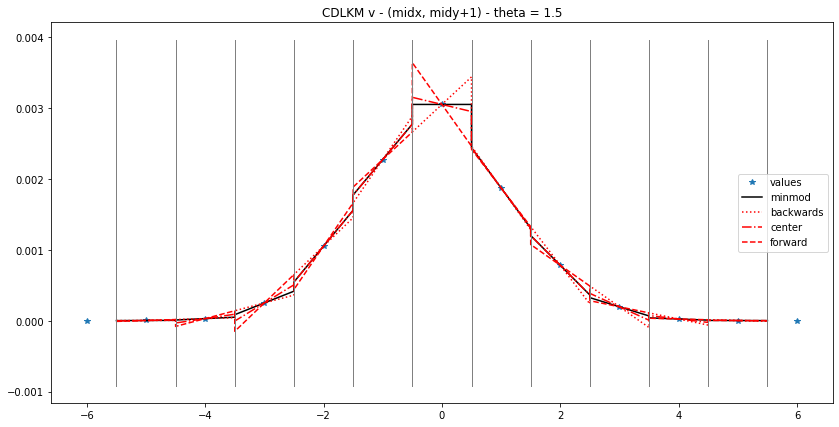

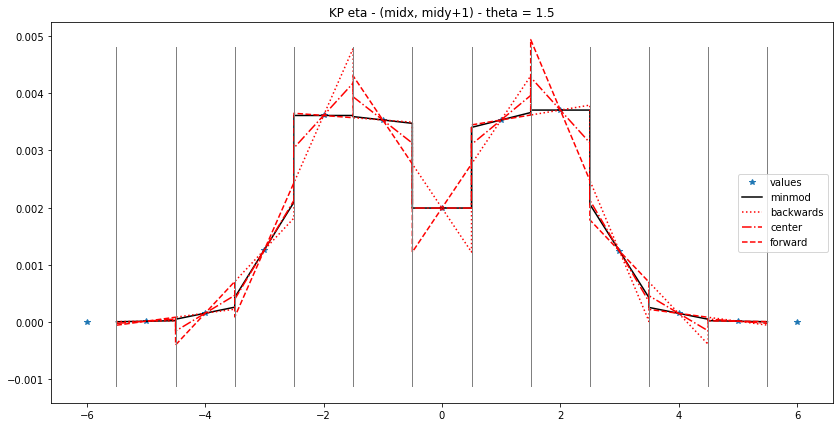

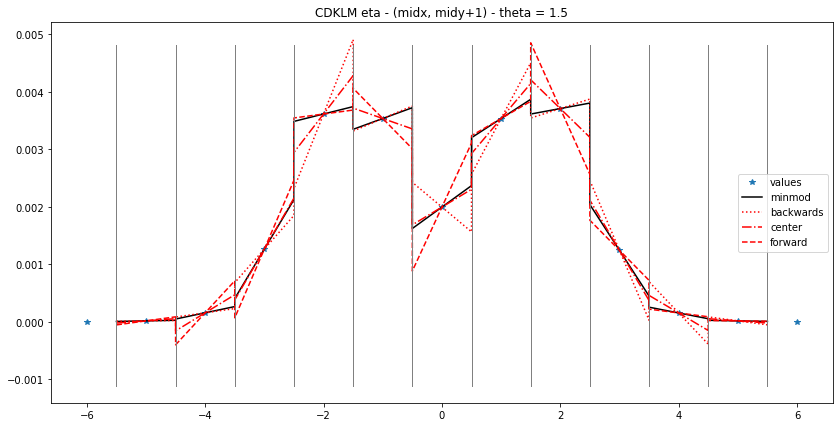

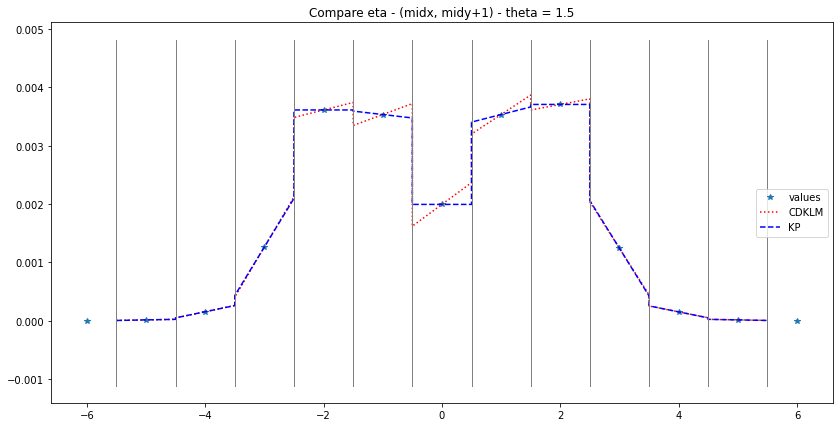

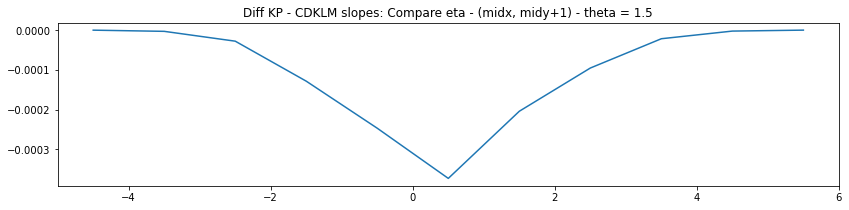

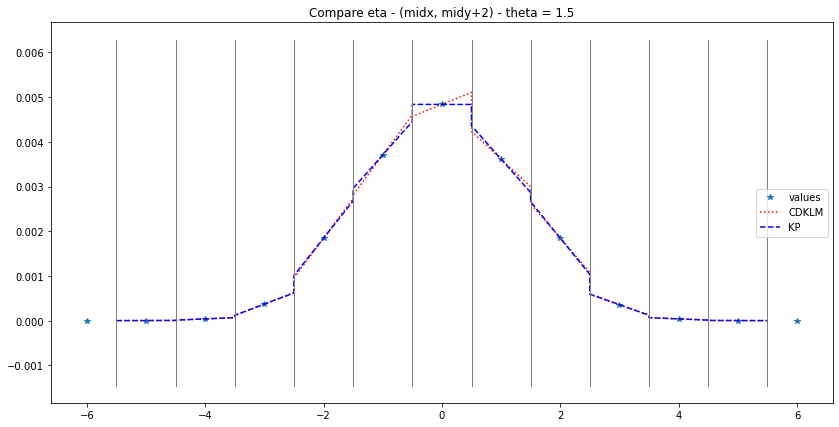

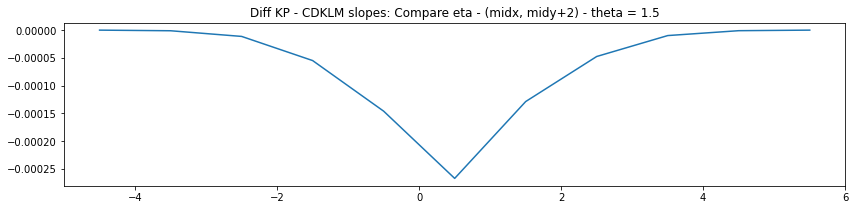

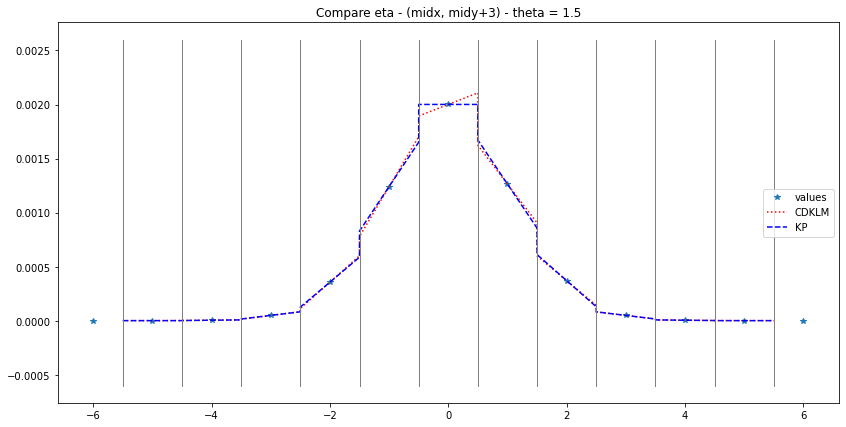

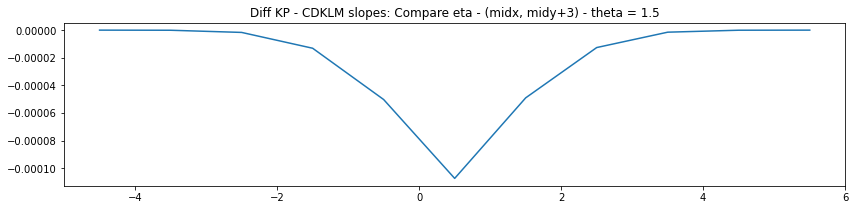

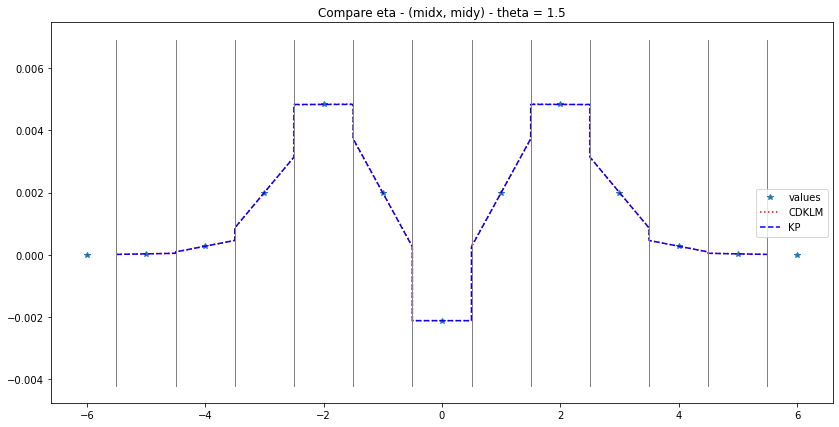

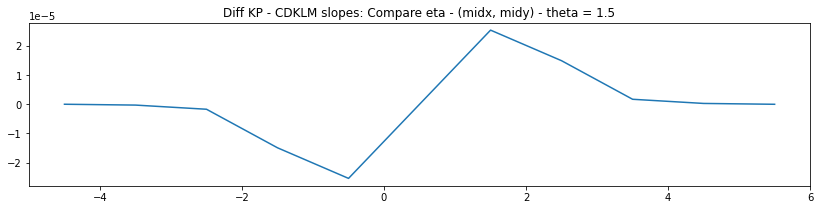

In [18]:
def minmodRaw(backward, center, forward):
     out = np.zeros_like(center)
     for i in range(len(out)):
          if   (backward[i] > 0) and (center[i] > 0) and (forward[i] > 0):
               out[i] =  min(backward[i], center[i], forward[i])
          elif (backward[i] < 0) and (center[i] < 0) and (forward[i] < 0):
               out[i] =  max(backward[i], center[i], forward[i])
          else:
               out[i] =  0.0
     return out



def minmodSlopes(data, theta):
     backward, center, forward = fd_slopes(data)
     return minmodRaw(theta*backward, center, theta*forward)

def fd_slopes(data):
     backward = (data[1:-1] - data[:-2] )
     center   = (data[2:]   - data[:-2] )/2
     forward  = (data[2:]   - data[1:-1])
     return backward, center, forward     

def reconstruct(data, data_x):
     assert(len(data) - 2 == len(data_x))
     data_up   = data[1:-1] + 0.5*data_x 
     data_down = data[1:-1] - 0.5*data_x 
     return data_up, data_down

def fd_slopes_K(eta, v, args):
     g = args["g"]
     dx = args["dx"]
     f = args["f"]
     const = f*dx/(2*g)
     backward =     g*(eta[1:-1] - eta[:-2] ) - const*(v[1:-1] +   v[:-2])
     center   = 0.5*g*(eta[2:]   - eta[:-2] ) - const*(v[2:]   + 2*v[1:-1] + v[:-2])
     forward  =     g*(eta[2:]   - eta[1:-1]) - const*(v[2:]   +   v[1:-1])
     return backward, center, forward     

def reconstruct_eta(eta, v, K_x, args):
     dx = args["dx"]
     f  = args["f"]
     g  = args["g"]
     eta_up   = eta[1:-1] + 0.5*(K_x + dx*f*v[1:-1])/g
     eta_down = eta[1:-1] - 0.5*(K_x + dx*f*v[1:-1])/g
     print("extra when reconstruct eta CDKLM: ", dx*f*v[1:-1]/g)
     return eta_up, eta_down

def merge_up_and_down(up, down):
     N = (len(up) - 1)*2 + 2
     combo = np.zeros(N)
     combo[0] = down[0]
     for i in range(1, len(down)):
          combo[2*i - 1] = up[i-1]
          combo[2*i    ] = down[i]
     combo[-1] = up[-1]
     return combo

def plotValuesAndAllSlopes(data, theta, title):
     data_bw, data_c, data_fw = fd_slopes(data)
     data_x = minmodSlopes(data, theta)

     Ndata = len(data)
     x = np.arange(-(Ndata//2), Ndata//2+1)
     x_down = x[1:-1]  - 0.5
     x_up   = x[1:-1] + 0.5
     x_combo = merge_up_and_down(x_up, x_down)

     y_span = max(data) - min(data)

     def _plot_reconstructed(data, data_x, style, label):
          data_x_up, data_x_down = reconstruct(data, data_x)
          data_x_combo = merge_up_and_down(data_x_up, data_x_down)
          plt.plot(x_combo, data_x_combo, style, label=label)
     
     fig = plt.figure(figsize=(14,7))
     plt.plot(x, data, '*', label='values')
     _plot_reconstructed(data, data_x,  'k-',  "minmod")
     _plot_reconstructed(data, data_bw, 'r:',  "backwards")
     _plot_reconstructed(data, data_c,  'r-.', "center")
     _plot_reconstructed(data, data_fw, 'r--', "forward")
     
     for i in range(len(x)-1):
          plt.plot([x[i]+0.5, x[i]+0.5], [max(data)+0.3*y_span, min(data)-0.3*y_span], 
                    linewidth=1, color='grey')
     plt.legend()
     plt.title(title + " - theta = " + str(theta))

def plotValuesAndAllSlopes_cdklm_eta(eta, v, args, theta, title):
     K_bw, K_c, K_fw = fd_slopes_K(eta, v, args)
     K_x = minmodRaw(theta*K_bw, K_c, theta*K_fw)

     Ndata = len(eta)
     x = np.arange(-(Ndata//2), Ndata//2+1)
     x_down = x[1:-1]  - 0.5
     x_up   = x[1:-1] + 0.5
     x_combo = merge_up_and_down(x_up, x_down)

     y_span = max(eta) - min(eta)

     def _plot_reconstructed_eta(eta, v, K_x, style, label):
          eta_x_up, eta_x_down = reconstruct_eta(eta, v, K_x, args)
          eta_x_combo = merge_up_and_down(eta_x_up, eta_x_down)
          plt.plot(x_combo, eta_x_combo, style, label=label)
     
     fig = plt.figure(figsize=(14,7))
     plt.plot(x, eta, '*', label='values')
     _plot_reconstructed_eta(eta, v, K_x,  'k-',  "minmod")
     _plot_reconstructed_eta(eta, v, K_bw, 'r:',  "backwards")
     _plot_reconstructed_eta(eta, v, K_c,  'r-.', "center")
     _plot_reconstructed_eta(eta, v, K_fw, 'r--', "forward")
     
     for i in range(len(x)-1):
          plt.plot([x[i]+0.5, x[i]+0.5], [max(eta)+0.3*y_span, min(eta)-0.3*y_span], 
                    linewidth=1, color='grey')
     plt.legend()
     plt.title(title + " - theta = " + str(theta))

def plotAndCompareEta(eta, v, args, theta, title):
     K_bw, K_c, K_fw = fd_slopes_K(eta, v, args)
     K_x = minmodRaw(theta*K_bw, K_c, theta*K_fw)
     eta_x = minmodSlopes(eta, theta)

     Ndata = len(eta)
     x = np.arange(-(Ndata//2), Ndata//2+1)
     x_down = x[1:-1]  - 0.5
     x_up   = x[1:-1] + 0.5
     x_combo = merge_up_and_down(x_up, x_down)

     y_span = max(eta) - min(eta)

     def _plot_reconstructed_eta(eta, v, K_x, style, label):
          eta_x_up, eta_x_down = reconstruct_eta(eta, v, K_x, args)
          eta_x_combo = merge_up_and_down(eta_x_up, eta_x_down)
          plt.plot(x_combo, eta_x_combo, style, label=label)
     
     fig = plt.figure(figsize=(14,7))
     plt.plot(x, eta, '*', label='values')

     # CDKLM eta:
     cdklm_up, cdklm_down = reconstruct_eta(eta, v, K_x, args)
     cdklm_combo = merge_up_and_down(cdklm_up, cdklm_down)
     plt.plot(x_combo, cdklm_combo, "r:", label="CDKLM")

     # KP eta:
     kp_up, kp_down = reconstruct(eta, eta_x)
     kp_combo = merge_up_and_down(kp_up, kp_down)
     plt.plot(x_combo, kp_combo, "b--", label="KP")

     for i in range(len(x)-1):
          plt.plot([x[i]+0.5, x[i]+0.5], [max(eta)+0.3*y_span, min(eta)-0.3*y_span], 
                    linewidth=1, color='grey')
     plt.legend()
     plt.title(title + " - theta = " + str(theta))

     plt.figure(figsize=(14,3))
     plt.plot(x_up, kp_up - cdklm_up)
     plt.title("Diff KP - CDKLM slopes: " + title + " - theta = " + str(theta))

def fvm_reconstruct_x(eta_in, hu_in, hv_in, x, y, theta, plotTitle, args, H=60.0, span=2, onlyCompareEta=False):
     eta = eta_in[y, x-span:x+span+1]
     hu  =  hu_in[y, x-span:x+span+1]
     hv  =  hv_in[y, x-span:x+span+1]
     
     # Reconstruction variables [u, v, K]. 
     # Lx is never used
     u = hu/(eta+H)
     v = hv/(eta+H)

     # Find u and v slopes (really slopes*dx)
     u_bw, u_c, u_fw = fd_slopes(u)
     u_x = minmodSlopes(u, theta)
     u_up, u_down = reconstruct(u, u_x)
     
     if not onlyCompareEta:
          plotValuesAndAllSlopes(u, theta, "CDKLM u - " + plotTitle)
          plotValuesAndAllSlopes(hu, theta, "KP hu - " + plotTitle)
          plotValuesAndAllSlopes(v, theta, "CDLKM v - " + plotTitle)
          plotValuesAndAllSlopes(eta, theta, "KP eta - " + plotTitle)
          plotValuesAndAllSlopes_cdklm_eta(eta, v, args, theta, "CDKLM eta - " + plotTitle)
     plotAndCompareEta(eta, v, args, theta, "Compare eta - " + plotTitle)
     #plotAndCompare_hu(eta, v, u, hu, theta, "Compare hu - " + plotTitle)

theta = 1.5
fvm_reconstruct_x(eta, hu, hv, midx, midy+1, theta, "(midx, midy+1)", sim_args, span=6)
fvm_reconstruct_x(eta, hu, hv, midx, midy+2, theta, "(midx, midy+2)", sim_args, span=6, onlyCompareEta=True)
fvm_reconstruct_x(eta, hu, hv, midx, midy+3, theta, "(midx, midy+3)", sim_args, span=6, onlyCompareEta=True)
fvm_reconstruct_x(eta, hu, hv, midx, midy+0, theta, "(midx, midy)", sim_args, span=6, onlyCompareEta=True)

#fvm_reconstruct_x(eta, hu, hv, midx, midy, 1.5, "cdklm (midx, midy)", sim_args, span=6)

In [ ]:
-(7//2)

-3